In [1]:
#pip install ipynb

Connected to: www.jacobkamminga.nl:3306
Test subject: Galoway
Epoch 1/2
71/71 [==============================] - 6s 62ms/step - loss: 1.2094 - accuracy: 0.5416 - val_loss: 0.2630 - val_accuracy: 0.9258
Epoch 2/2
71/71 [==============================] - 4s 51ms/step - loss: 0.2174 - accuracy: 0.9366 - val_loss: 0.1901 - val_accuracy: 0.9392


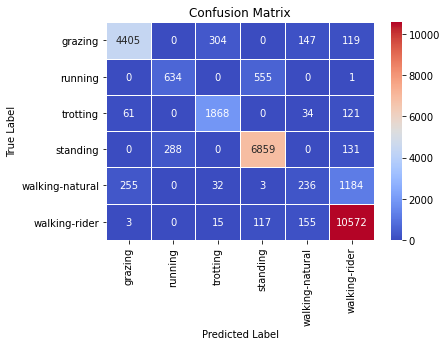


Accuracy on test data: 0.87
Test subject: Patron
Epoch 1/2
89/89 [==============================] - 7s 60ms/step - loss: 1.1030 - accuracy: 0.5958 - val_loss: 0.2352 - val_accuracy: 0.9202
Epoch 2/2
89/89 [==============================] - 5s 54ms/step - loss: 0.2245 - accuracy: 0.9221 - val_loss: 0.1985 - val_accuracy: 0.9305


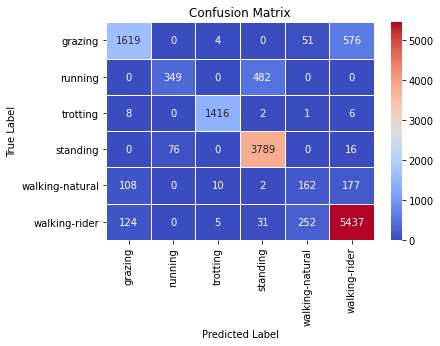


Accuracy on test data: 0.87
Test subject: Happy


In [ ]:
import importlib
import ipynb.fs.full.db as db
import ipynb.fs.full.preprocessing as preprocessing
db = importlib.reload(db)
preprocessing = importlib.reload(preprocessing)

import keras
#from db import DBParameters as dbp
#from db import connect
#from preprocessing import *
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns
import uuid

import glob
import numpy as np

# Hyper-parameters
BATCH_SIZE = 600
EPOCHS = 2

# Datasets
PATH = 'Data/*'
FILES = sorted(glob.glob(PATH))

# Set to false to disable database support
db_enabled = True

#Include the model description here, as this is NOT included in the parameters
DESCRIPTION = "Neural Network with 6 layers (Reshape, Dense x3, Flatten, Dense)"
PARAMETERS = "TIME_PERIOD: " + str(preprocessing.TIME_PERIODS) + ", STEP_DISTANCE: " + str(preprocessing.STEP_DISTANCE) + ", BATCH_SIZE: " + str(BATCH_SIZE) + ", EPOCHS: " + str(EPOCHS)

def build_classifier(input_shape, num_classes):
    model_m = Sequential()
    model_m.add(Reshape((preprocessing.TIME_PERIODS, 6), input_shape=(input_shape,)))
    model_m.add(Dense(100, activation='relu'))
    model_m.add(Dense(100, activation='relu'))
    model_m.add(Dense(100, activation='relu'))
    model_m.add(Flatten())
    model_m.add(Dense(num_classes, activation='softmax'))
    return model_m


def train_classifier(input, output, input_shape, num_classes):
    model = build_classifier(input_shape, num_classes)

    callbacks_list = [
        keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
    ]

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
    history = model.fit(input,
                        output,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        callbacks=callbacks_list,
                        validation_split=0.2,
                        verbose=1)

    return history, model

def show_confusion_matrix(validations, predictions, model_m):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=preprocessing.LABELS,
                yticklabels=preprocessing.LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    precision_per_class, recall_per_class, f_score_per_class, _ = metrics.precision_recall_fscore_support(validations, predictions, zero_division=0)
    _, recall_avg, f_score_avg, _ = metrics.precision_recall_fscore_support(validations, predictions, pos_label=None, average="weighted", zero_division=0)
    mcc = metrics.matthews_corrcoef(validations, predictions)
    balanced_accuracy = metrics.balanced_accuracy_score(validations, predictions)
    accuracy = metrics.accuracy_score(validations, predictions)
    
    print('\nAccuracy on test data: %0.2f' % accuracy)
    
    #print(classification_report(max_y_test, max_y_pred_test, output_dict=True))
    return matrix, precision_per_class, recall_per_class, f_score_per_class, recall_avg, f_score_avg, mcc, balanced_accuracy, accuracy


def main():
    if db_enabled:
        database = db.connect(db.DB_NAME, db.USER, db.PASSWORD, db.HOST, db.PORT)
        experiment_class, activity_class = db.get_classes(database)

    df = preprocessing.create_dataframe(FILES)
    
    uid = uuid.uuid4()
    for s in preprocessing.SUBJECTS:
        print("Test subject: "+str(s))
        xtrain, ytrain, xtest, ytest, input_shape, num_classes = preprocessing.preprocess(df, s)

        history, model = train_classifier(xtrain, ytrain, input_shape, num_classes)
        test_prediction = model.predict(xtest)
        
        max_test_prediction = np.argmax(test_prediction, axis=1)
        max_y_test = np.argmax(ytest, axis=1)
        
        matrix, precision_per_class, recall_per_class, f_score_per_class, recall_avg, f_score_avg, mcc_score, balanced_acc, acc = show_confusion_matrix(max_y_test, max_test_prediction, model) #print confusion matrix and get evaluation results of the test data

        for act in preprocessing.LABELS:
            index = preprocessing.LABELS.index(act)
            db.save_activity(activity_class, uid, s, act, matrix, index, recall_per_class[index], precision_per_class[index])
            
        db.save_experiment(experiment_class, uid, s, acc, balanced_acc, f_score_avg, mcc_score, recall_avg, matrix, PARAMETERS, DESCRIPTION)
    
if __name__ == '__main__':
    main()

#Uncomment if you want to print a specific confusion matrix. Replace the key with the experiment key.
#db.show_confusion_matrix_from_db(key="f6fe1f8d-52e3-4015-af8f-c64e62f73ccb")

#input the selections here to print data from the database. 
#For example, replace username=None with username="maartjehuveneers" to select on Maartje's results
# db.show_results(key=None, 
#              username=None, 
#              test_horse=None, 
#              day=None,
#              month=None,
#              activity=None)